In [1]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [3]:
import gnwrapper

In [5]:
env_id = "CarRacing-v2"
NUM_CPU = 16  # Number0of processes to use

In [7]:
# env = gym.make(env_id)
# env = SubprocVecEnv([env]*NUM_CPU)
env = DummyVecEnv([lambda: gym.make(env_id)])

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
-----------------------------
| time/              |      |
|    fps             | 253  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------


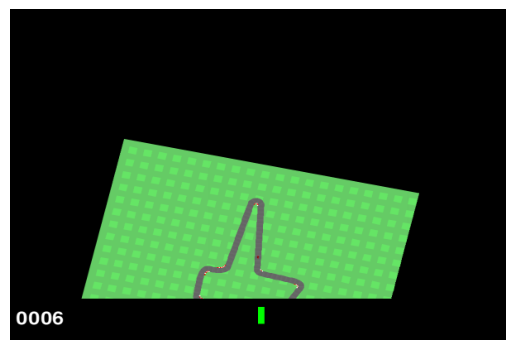

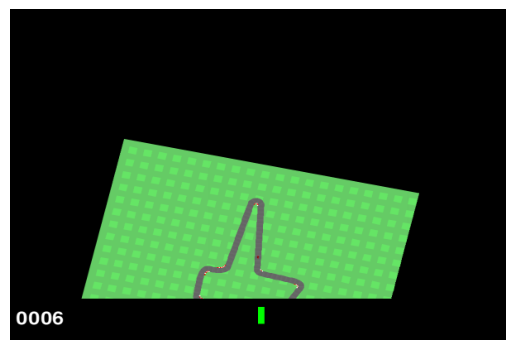

In [8]:
env = gym.make(env_id, render_mode="rgb_array")
env = gnwrapper.Animation(env)

env = DummyVecEnv([lambda: env])
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()